# Imports and environment loading

In [4]:
from utils.model import MNmodelPartAM_Dueling
import pickle
import torch
import os
from matplotlib import pyplot as plt
from utils.learner import Segmenter, RLLearner
from utils.env_utils import load_env
import cv2
from tqdm import tqdm
torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_build = 'NAVIndoor/maze' #environment path
env, behavior_name,channel_env = load_env(train_build,10,0,0,1)


[UnityMemory] Configuration Parameters - Can be set up in boot.config
    "memorysetup-bucket-allocator-granularity=16"
    "memorysetup-bucket-allocator-bucket-count=8"
    "memorysetup-bucket-allocator-block-size=4194304"
    "memorysetup-bucket-allocator-block-count=1"
    "memorysetup-main-allocator-block-size=16777216"
    "memorysetup-thread-allocator-block-size=16777216"
    "memorysetup-gfx-main-allocator-block-size=16777216"
    "memorysetup-gfx-thread-allocator-block-size=16777216"
    "memorysetup-cache-allocator-block-size=4194304"
    "memorysetup-typetree-allocator-block-size=2097152"
    "memorysetup-profiler-bucket-allocator-granularity=16"
    "memorysetup-profiler-bucket-allocator-bucket-count=8"
    "memorysetup-profiler-bucket-allocator-block-size=4194304"
    "memorysetup-profiler-bucket-allocator-block-count=1"
    "memorysetup-profiler-allocator-block-size=16777216"
    "memorysetup-profiler-editor-allocator-block-size=1048576"
    "memorysetup-temp-allocator-siz

# Training

In [ ]:
ac = {0:[1,0]
     ,1:[0,1]
     ,2:[0,-1]
     ,3:[-1,0]
     #,4:[1,1]
     #,5:[1,-1]
     #,6:[-1,1]
     #,7:[-1,-1]
     #,8:[0,0]
     } #action mapper. Includes 9 possibilities with combinations for moving (first parameter : 1 = forward, -1 = backward) and rotation (second parameter : -1 = left, 1 = right). On our experiments we only use 4.
output_classes = len(ac)


erase = False
budget = 100000 
n_frames = 3

scale = 3 #model size
aes = 20 #action embedding space length
am = 20 #action memory buffer length 
ahes = 150 #action memory representation length


buffer_size = 12000 #replay buffer size. Big sizes may not fill in small memory devices.
gamma = 0.97
train_every = 5 #backward frequency



update_type = 'hard' #update type for Q theta - ('hard' or 'soft')
tau = 0.01 # soft update parameter if update_type = 'e
update_every = 50 #update frequency of Q theta - if update_type = 'hard'


learning_rate = 0.001
batch_size = 128

episode_duration = 400
epsilon_decrease = int(budget/3)
epsilon_min = 0.15

#model = MNmodelPartAM_Dueling(scale=scale,output=output_classes,dropout=0,n_actions = output_classes,am = am,aes = aes, ahes = ahes,n_frames = n_frames)
#target_model = MNmodelPartAM_Dueling(scale=scale,output=output_classes,dropout=0, n_actions = output_classes,am = am, aes = aes, ahes = ahes, n_frames = n_frames)

env_settings = {"coin_proba":1, #parameters for the environments. 
 "increase_obstacle_proba":1, #Linear increase in obstacle proportion until max_obstacle_proba is reached
 "move_speed":[1,1], #Movement speed
 "turn_speed":[150,150], #Rotation speed
 "momentum":[0,0], #Inertial momentum
 "decrease_reward_on_stay":0, #decrease reward when OnStayCollided method is called
 "coin_visible":1, #Coins visibility
 "max_obstacle_proba":0.3} #Obstacle proportion


name = '3_1_1_1-1_0_floor_dueling'



#model =  SFO_model(output_classes=output_classes,scale_fl = scale, model_class = MNmodelPart,dropout=0)
#target_model = SFO_model(output_classes=output_classes,scale_fl = scale, model_class = MNmodelPart,dropout=0)

model = MNmodelPartAM_Dueling(scale=scale,output=output_classes,dropout=0,n_actions = output_classes,am = am,aes = aes, ahes = ahes,n_frames=3)
target_model = MNmodelPartAM_Dueling(scale=scale,output=output_classes,dropout=0, n_actions = output_classes,am = am, aes = aes, ahes = ahes,n_frames=3)



Learner = RLLearner(env=env,
                    model=model,
                    target_model=target_model,
                    learning_rate = learning_rate,
                    update_every = update_every, 
                    buffer_size= buffer_size, 
                    gamma = gamma, 
                    batch_size = batch_size,
                    epsilon_decrease=epsilon_decrease,
                    episode_duration = episode_duration,
                    action_mapper = ac,
                    segmenter = Segmenter(True), #Segmenter argument is ground segmentation (with value 0.5)
                    train_every = train_every,
                    device = device,
                    do_clip = 0, #save a clip after each episode.
                    epsilon_min = epsilon_min,
                    action_memory = am,
                   update_type = update_type,
                   tau= tau,
                   using_seg_input=True,
                   n_frames = n_frames,
                   channel_env = channel_env,
                   budget = budget,
                   env_settings = env_settings,
                   eval_n = 3) #number of episodes used for evaluation.

    


In [6]:
Learner.train_model()

rl_loss : 4.876586444879649e-06:   0%|   | 405/100000 [00:13<8:20:19,  3.32it/s]

Mean reward result after episode 1 :  -4.333333333333333


rl_loss : 0.006740593817085028:   1%|    | 810/100000 [00:26<5:15:02,  5.25it/s]

Mean reward result after episode 2 :  0.0


rl_loss : 0.026567846536636353:   1%|   | 1214/100000 [00:40<5:40:07,  4.84it/s]

Mean reward result after episode 3 :  -1.3333333333333333


rl_loss : 0.0270792618393898:   2%|     | 1607/100000 [00:54<7:00:09,  3.90it/s]

Mean reward result after episode 4 :  -5.0


rl_loss : 0.02139129489660263:   2%|    | 2006/100000 [01:07<7:42:19,  3.53it/s]

Mean reward result after episode 5 :  -4.666666666666667


rl_loss : 0.030118616297841072:   2%|   | 2409/100000 [01:20<5:22:14,  5.05it/s]

Mean reward result after episode 6 :  0.0


rl_loss : 0.007451078854501247:   3%|   | 2810/100000 [01:34<5:50:06,  4.63it/s]

Mean reward result after episode 7 :  -52.0


rl_loss : 0.01875687763094902:   3%|▏   | 3205/100000 [01:48<8:05:59,  3.32it/s]

Mean reward result after episode 8 :  0.0


rl_loss : 0.0174263846129179:   4%|▏    | 3610/100000 [02:01<5:59:35,  4.47it/s]

Mean reward result after episode 9 :  1.6666666666666667


rl_loss : 0.014296168461441994:   4%|   | 4005/100000 [02:15<7:36:15,  3.51it/s]

Mean reward result after episode 10 :  0.0


rl_loss : 0.03729017823934555:   4%|▏   | 4407/100000 [02:28<6:47:44,  3.91it/s]

Mean reward result after episode 11 :  0.0


rl_loss : 0.02894606813788414:   5%|▏   | 4806/100000 [02:41<8:43:01,  3.03it/s]

Mean reward result after episode 12 :  0.0


rl_loss : 0.025628654286265373:   5%|▏  | 5207/100000 [02:55<8:13:59,  3.20it/s]

Mean reward result after episode 13 :  1.6666666666666667


rl_loss : 0.035873010754585266:   6%|▏  | 5607/100000 [03:09<6:30:35,  4.03it/s]

Mean reward result after episode 14 :  0.0


rl_loss : 0.08043017983436584:   6%|▏   | 6009/100000 [03:23<6:16:39,  4.16it/s]

Mean reward result after episode 15 :  0.0


rl_loss : 0.08234816789627075:   6%|▎   | 6405/100000 [03:36<7:13:47,  3.60it/s]

Mean reward result after episode 16 :  2.0


rl_loss : 0.010093513876199722:   7%|▏  | 6806/100000 [03:49<7:41:25,  3.37it/s]

Mean reward result after episode 17 :  7.0


rl_loss : 0.024532120674848557:   7%|▏  | 7207/100000 [04:03<7:54:06,  3.26it/s]

Mean reward result after episode 18 :  -0.6666666666666666


rl_loss : 0.004822808317840099:   8%|▏  | 7606/100000 [04:17<7:48:28,  3.29it/s]

Mean reward result after episode 19 :  0.0


rl_loss : 0.013876717537641525:   8%|▏  | 8010/100000 [04:31<5:15:12,  4.86it/s]

Mean reward result after episode 20 :  2.6666666666666665


rl_loss : 0.045047931373119354:   8%|▎  | 8406/100000 [04:45<8:15:54,  3.08it/s]

Mean reward result after episode 21 :  0.0


rl_loss : 0.012399880215525627:   9%|▎  | 8807/100000 [04:59<7:33:11,  3.35it/s]

Mean reward result after episode 22 :  0.0


rl_loss : 0.0013668718747794628:   9%|▏ | 9205/100000 [05:12<7:32:15,  3.35it/s]

Mean reward result after episode 23 :  0.0


rl_loss : 0.018876509740948677:  10%|▎  | 9610/100000 [05:27<5:14:15,  4.79it/s]

Mean reward result after episode 24 :  1.6666666666666667


rl_loss : 0.0024202968925237656:  10%| | 10008/100000 [05:40<5:31:04,  4.53it/s]

Mean reward result after episode 25 :  0.0


rl_loss : 0.06987448036670685:  10%|▎  | 10410/100000 [05:54<4:53:43,  5.08it/s]

Mean reward result after episode 26 :  4.0


rl_loss : 0.012464994564652443:  11%|▏ | 10806/100000 [06:07<7:50:26,  3.16it/s]

Mean reward result after episode 27 :  14.666666666666666


rl_loss : 0.020310619845986366:  11%|▏ | 11206/100000 [06:22<8:24:39,  2.93it/s]

Mean reward result after episode 28 :  0.0


rl_loss : 0.003963051363825798:  12%|▏ | 11610/100000 [06:36<6:21:27,  3.86it/s]

Mean reward result after episode 29 :  8.0


rl_loss : 0.00457813311368227:  12%|▎  | 12010/100000 [06:49<4:58:50,  4.91it/s]

Mean reward result after episode 30 :  0.0


rl_loss : 0.053324248641729355:  12%|▏ | 12408/100000 [07:03<5:38:13,  4.32it/s]

Mean reward result after episode 31 :  0.0


rl_loss : 0.008342444896697998:  13%|▎ | 12809/100000 [07:17<5:39:21,  4.28it/s]

Mean reward result after episode 32 :  0.0


rl_loss : 0.010991876013576984:  13%|▎ | 13206/100000 [07:32<9:12:55,  2.62it/s]

Mean reward result after episode 33 :  -0.6666666666666666


rl_loss : 0.008396448567509651:  14%|▎ | 13610/100000 [07:46<5:12:03,  4.61it/s]

Mean reward result after episode 34 :  0.0


rl_loss : 0.0113391587510705:  14%|▌   | 14010/100000 [07:59<5:30:55,  4.33it/s]

Mean reward result after episode 35 :  8.333333333333334


rl_loss : 0.008138983510434628:  14%|▎ | 14407/100000 [08:13<5:09:17,  4.61it/s]

Mean reward result after episode 36 :  6.666666666666667


rl_loss : 0.008540309965610504:  15%|▎ | 14807/100000 [08:27<7:07:53,  3.32it/s]

Mean reward result after episode 37 :  1.3333333333333333


rl_loss : 0.05568484961986542:  15%|▍  | 15205/100000 [08:41<7:29:49,  3.14it/s]

Mean reward result after episode 38 :  0.0


rl_loss : 0.00996337179094553:  16%|▍  | 15606/100000 [08:54<7:02:37,  3.33it/s]

Mean reward result after episode 39 :  22.0


rl_loss : 0.008744328282773495:  16%|▎ | 16010/100000 [09:09<5:07:30,  4.55it/s]

Mean reward result after episode 40 :  0.0


rl_loss : 0.0009329174645245075:  16%|▏| 16408/100000 [09:22<5:13:05,  4.45it/s]

Mean reward result after episode 41 :  0.0


rl_loss : 0.031485412269830704:  17%|▎ | 16806/100000 [09:37<7:56:38,  2.91it/s]

Mean reward result after episode 42 :  8.333333333333334


rl_loss : 0.03149540349841118:  17%|▌  | 17209/100000 [09:50<5:16:09,  4.36it/s]

Mean reward result after episode 43 :  1.3333333333333333


rl_loss : 0.003922109957784414:  18%|▎ | 17606/100000 [10:04<8:15:56,  2.77it/s]

Mean reward result after episode 44 :  2.3333333333333335


rl_loss : 0.051526740193367004:  18%|▎ | 18009/100000 [10:18<5:36:00,  4.07it/s]

Mean reward result after episode 45 :  6.666666666666667


rl_loss : 0.0012781216064468026:  18%|▏| 18407/100000 [10:32<5:56:16,  3.82it/s]

Mean reward result after episode 46 :  0.0


rl_loss : 0.0056432695128023624:  19%|▏| 18806/100000 [10:46<7:47:09,  2.90it/s]

Mean reward result after episode 47 :  0.0


rl_loss : 0.0030874914955347776:  19%|▏| 19207/100000 [11:00<5:13:14,  4.30it/s]

Mean reward result after episode 48 :  0.0


rl_loss : 0.013476879335939884:  20%|▍ | 19610/100000 [11:13<5:24:25,  4.13it/s]

Mean reward result after episode 49 :  0.0


rl_loss : 0.0013607298023998737:  20%|▏| 20007/100000 [11:27<5:23:35,  4.12it/s]

Mean reward result after episode 50 :  0.0


rl_loss : 0.0175099465996027:  20%|▊   | 20408/100000 [11:42<5:08:45,  4.30it/s]

Mean reward result after episode 51 :  -1.6666666666666667


rl_loss : 0.003973944578319788:  21%|▍ | 20810/100000 [11:56<4:29:00,  4.91it/s]

Mean reward result after episode 52 :  1.6666666666666667


rl_loss : 0.07132488489151001:  21%|▋  | 21208/100000 [12:10<5:14:33,  4.17it/s]

Mean reward result after episode 53 :  0.0


rl_loss : 0.11575286090373993:  22%|▋  | 21605/100000 [12:24<6:57:48,  3.13it/s]

Mean reward result after episode 54 :  2.0


rl_loss : 0.02780723012983799:  22%|▋  | 22007/100000 [12:38<5:13:57,  4.14it/s]

Mean reward result after episode 55 :  25.333333333333332


rl_loss : 0.06738411635160446:  22%|▋  | 22410/100000 [12:52<4:32:08,  4.75it/s]

Mean reward result after episode 56 :  0.0


rl_loss : 0.0161807332187891:  23%|▉   | 22805/100000 [13:05<6:28:29,  3.31it/s]

Mean reward result after episode 57 :  0.0


rl_loss : 0.0029663473833352327:  23%|▏| 23206/100000 [13:19<6:33:03,  3.26it/s]

Mean reward result after episode 58 :  2.6666666666666665


rl_loss : 0.03422060236334801:  24%|▋  | 23609/100000 [13:33<5:15:12,  4.04it/s]

Mean reward result after episode 59 :  0.0


rl_loss : 0.016567353159189224:  24%|▍ | 24005/100000 [13:47<6:39:04,  3.17it/s]

Mean reward result after episode 60 :  2.3333333333333335


rl_loss : 0.014607577584683895:  24%|▍ | 24410/100000 [14:01<4:27:29,  4.71it/s]

Mean reward result after episode 61 :  12.666666666666666


rl_loss : 0.03574753552675247:  25%|▋  | 24807/100000 [14:14<5:30:45,  3.79it/s]

Mean reward result after episode 62 :  16.666666666666668


rl_loss : 0.0121083939447999:  25%|█   | 25207/100000 [14:28<6:35:18,  3.15it/s]

Mean reward result after episode 63 :  5.666666666666667


rl_loss : 0.0023014452308416367:  26%|▎| 25610/100000 [14:43<5:01:35,  4.11it/s]

Mean reward result after episode 64 :  1.6666666666666667


rl_loss : 0.09720266610383987:  26%|▊  | 26010/100000 [14:57<4:18:29,  4.77it/s]

Mean reward result after episode 65 :  9.333333333333334


rl_loss : 0.005529291462153196:  26%|▌ | 26410/100000 [15:10<4:29:01,  4.56it/s]

Mean reward result after episode 66 :  8.333333333333334


rl_loss : 0.023097878322005272:  27%|▌ | 26809/100000 [15:24<4:24:55,  4.60it/s]

Mean reward result after episode 67 :  0.0


rl_loss : 0.01035962626338005:  27%|▊  | 27206/100000 [15:39<6:41:32,  3.02it/s]

Mean reward result after episode 68 :  -2.0


rl_loss : 0.015009630471467972:  28%|▌ | 27606/100000 [15:53<5:10:33,  3.89it/s]

Mean reward result after episode 69 :  7.0


rl_loss : 0.015875419601798058:  28%|▌ | 28009/100000 [16:07<5:21:28,  3.73it/s]

Mean reward result after episode 70 :  -1.0


rl_loss : 0.009719639085233212:  28%|▌ | 28408/100000 [16:21<4:34:12,  4.35it/s]

Mean reward result after episode 71 :  -3.0


rl_loss : 0.0013309246860444546:  29%|▎| 28810/100000 [16:35<4:33:31,  4.34it/s]

Mean reward result after episode 72 :  1.0


rl_loss : 0.014811194501817226:  29%|▌ | 29208/100000 [16:48<4:22:38,  4.49it/s]

Mean reward result after episode 73 :  -0.3333333333333333


rl_loss : 0.007861788384616375:  30%|▌ | 29604/100000 [17:03<6:52:54,  2.84it/s]

Mean reward result after episode 74 :  0.0


rl_loss : 0.07876163721084595:  30%|▉  | 30008/100000 [17:17<4:41:25,  4.15it/s]

Mean reward result after episode 75 :  13.0


rl_loss : 0.08949999511241913:  30%|▉  | 30407/100000 [17:31<4:28:50,  4.31it/s]

Mean reward result after episode 76 :  0.0


rl_loss : 0.02521315962076187:  31%|▉  | 30805/100000 [17:45<6:55:17,  2.78it/s]

Mean reward result after episode 77 :  7.666666666666667


rl_loss : 0.08057834208011627:  31%|▉  | 31209/100000 [17:59<4:23:09,  4.36it/s]

Mean reward result after episode 78 :  0.0


rl_loss : 0.14702436327934265:  32%|▉  | 31605/100000 [18:14<7:05:27,  2.68it/s]

Mean reward result after episode 79 :  0.3333333333333333


rl_loss : 0.015571082942187786:  32%|▋ | 32006/100000 [18:28<6:00:33,  3.14it/s]

Mean reward result after episode 80 :  12.666666666666666


rl_loss : 0.1746186763048172:  32%|█▎  | 32406/100000 [18:42<6:15:28,  3.00it/s]

Mean reward result after episode 81 :  -1.0


rl_loss : 0.02708227001130581:  33%|▉  | 32810/100000 [18:56<3:58:16,  4.70it/s]

Mean reward result after episode 82 :  26.333333333333332


rl_loss : 0.05595502257347107:  33%|▉  | 33201/100000 [19:10<5:55:37,  3.13it/s]

Mean reward result after episode 83 :  10.0


rl_loss : 0.0783972442150116:  34%|█▎  | 33608/100000 [19:24<4:55:21,  3.75it/s]

Mean reward result after episode 84 :  12.0


rl_loss : 0.02523595280945301:  34%|█  | 34009/100000 [19:39<3:50:49,  4.76it/s]

Mean reward result after episode 85 :  0.0


rl_loss : 0.07197216898202896:  34%|█  | 34406/100000 [19:53<6:12:07,  2.94it/s]

Mean reward result after episode 86 :  0.0


rl_loss : 0.019390782341361046:  35%|▋ | 34806/100000 [20:07<6:29:49,  2.79it/s]

Mean reward result after episode 87 :  2.6666666666666665


rl_loss : 0.06253574788570404:  35%|█  | 35204/100000 [20:21<6:37:22,  2.72it/s]

Mean reward result after episode 88 :  14.666666666666666


rl_loss : 0.0600171759724617:  36%|█▍  | 35607/100000 [20:36<4:46:16,  3.75it/s]

Mean reward result after episode 89 :  1.6666666666666667


rl_loss : 0.07583677768707275:  36%|█  | 36003/100000 [20:51<6:28:23,  2.75it/s]

Mean reward result after episode 90 :  4.0


rl_loss : 0.08130252361297607:  36%|█  | 36406/100000 [21:05<5:43:01,  3.09it/s]

Mean reward result after episode 91 :  26.333333333333332


rl_loss : 0.03494936227798462:  37%|█  | 36807/100000 [21:19<4:41:09,  3.75it/s]

Mean reward result after episode 92 :  0.0


rl_loss : 0.10873128473758698:  37%|█  | 37205/100000 [21:33<6:09:32,  2.83it/s]

Mean reward result after episode 93 :  3.3333333333333335


rl_loss : 0.05539362132549286:  38%|█▏ | 37610/100000 [21:48<4:03:56,  4.26it/s]

Mean reward result after episode 94 :  3.3333333333333335


rl_loss : 0.05441364645957947:  38%|█▏ | 38006/100000 [22:02<5:34:12,  3.09it/s]

Mean reward result after episode 95 :  0.0


rl_loss : 0.12402412295341492:  38%|█▏ | 38406/100000 [22:16<5:33:54,  3.07it/s]

Mean reward result after episode 96 :  4.666666666666667


rl_loss : 0.17150108516216278:  39%|█▏ | 38810/100000 [22:31<3:35:07,  4.74it/s]

Mean reward result after episode 97 :  9.0


rl_loss : 0.18869751691818237:  39%|█▏ | 39206/100000 [22:45<5:09:08,  3.28it/s]

Mean reward result after episode 98 :  0.0


rl_loss : 0.08407193422317505:  40%|█▏ | 39610/100000 [23:00<3:58:36,  4.22it/s]

Mean reward result after episode 99 :  8.666666666666666


rl_loss : 0.017194097861647606:  40%|▊ | 40006/100000 [23:14<5:34:01,  2.99it/s]

Mean reward result after episode 100 :  5.0


rl_loss : 0.03119475208222866:  40%|█▏ | 40409/100000 [23:28<3:37:14,  4.57it/s]

Mean reward result after episode 101 :  1.3333333333333333


rl_loss : 0.07087370753288269:  41%|█▏ | 40806/100000 [23:42<5:12:51,  3.15it/s]

Mean reward result after episode 102 :  0.3333333333333333


rl_loss : 0.059873852878808975:  41%|▊ | 41206/100000 [23:56<4:04:34,  4.01it/s]

Mean reward result after episode 103 :  20.333333333333332


rl_loss : 0.10948023945093155:  42%|█▏ | 41607/100000 [24:10<4:34:49,  3.54it/s]

Mean reward result after episode 104 :  15.333333333333334


rl_loss : 0.026723213493824005:  42%|▊ | 42010/100000 [24:25<4:06:44,  3.92it/s]

Mean reward result after episode 105 :  12.666666666666666


rl_loss : 0.09912320226430893:  42%|█▎ | 42409/100000 [24:39<3:49:33,  4.18it/s]

Mean reward result after episode 106 :  1.3333333333333333


rl_loss : 0.02584218978881836:  43%|█▎ | 42810/100000 [24:54<3:42:54,  4.28it/s]

Mean reward result after episode 107 :  6.666666666666667


rl_loss : 0.06504963338375092:  43%|█▎ | 43206/100000 [25:08<4:03:40,  3.88it/s]

Mean reward result after episode 108 :  9.333333333333334


rl_loss : 0.08941373229026794:  44%|█▎ | 43606/100000 [25:22<5:16:24,  2.97it/s]

Mean reward result after episode 109 :  12.666666666666666


rl_loss : 0.08032318949699402:  44%|█▎ | 44006/100000 [25:37<5:12:54,  2.98it/s]

Mean reward result after episode 110 :  3.3333333333333335


rl_loss : 0.05540868639945984:  44%|█▎ | 44406/100000 [25:51<5:07:58,  3.01it/s]

Mean reward result after episode 111 :  1.6666666666666667


rl_loss : 0.013982904143631458:  45%|▉ | 44808/100000 [26:06<3:24:40,  4.49it/s]

Mean reward result after episode 112 :  2.6666666666666665


rl_loss : 0.06122268736362457:  45%|█▎ | 45205/100000 [26:20<5:13:50,  2.91it/s]

Mean reward result after episode 113 :  7.333333333333333


rl_loss : 0.01906895451247692:  46%|█▎ | 45607/100000 [26:34<3:39:28,  4.13it/s]

Mean reward result after episode 114 :  7.0


rl_loss : 0.1312660276889801:  46%|█▊  | 46005/100000 [26:48<4:29:35,  3.34it/s]

Mean reward result after episode 115 :  1.6666666666666667


rl_loss : 0.7374078035354614:  46%|█▊  | 46405/100000 [27:03<4:29:58,  3.31it/s]

Mean reward result after episode 116 :  -1.3333333333333333


rl_loss : 0.018567735329270363:  47%|▉ | 46811/100000 [27:17<4:19:41,  3.41it/s]

Mean reward result after episode 117 :  2.0


rl_loss : 0.04295079782605171:  47%|█▍ | 47204/100000 [27:32<5:16:30,  2.78it/s]

Mean reward result after episode 118 :  8.333333333333334


rl_loss : 0.06245873123407364:  48%|█▍ | 47605/100000 [27:46<4:06:00,  3.55it/s]

Mean reward result after episode 119 :  21.0


rl_loss : 0.08958163857460022:  48%|█▍ | 48006/100000 [28:01<5:10:33,  2.79it/s]

Mean reward result after episode 120 :  -3.3333333333333335


rl_loss : 0.04424797743558884:  48%|█▍ | 48404/100000 [28:15<5:24:01,  2.65it/s]

Mean reward result after episode 121 :  3.3333333333333335


rl_loss : 0.036556653678417206:  49%|▉ | 48810/100000 [28:30<3:20:34,  4.25it/s]

Mean reward result after episode 122 :  6.0


rl_loss : 0.07020258903503418:  49%|█▍ | 49205/100000 [28:44<5:27:42,  2.58it/s]

Mean reward result after episode 123 :  11.666666666666666


rl_loss : 101.72300720214844:  50%|█▉  | 49609/100000 [28:59<3:30:52,  3.98it/s]

Mean reward result after episode 124 :  1.6666666666666667


rl_loss : 0.044688716530799866:  50%|█ | 50007/100000 [29:14<3:41:57,  3.75it/s]

Mean reward result after episode 125 :  3.0


rl_loss : 0.0779653936624527:  50%|██  | 50409/100000 [29:28<3:15:46,  4.22it/s]

Mean reward result after episode 126 :  12.0


rl_loss : 0.0314444974064827:  51%|██  | 50809/100000 [29:43<3:27:06,  3.96it/s]

Mean reward result after episode 127 :  26.0


rl_loss : 0.06621021032333374:  51%|█▌ | 51205/100000 [29:57<4:45:51,  2.85it/s]

Mean reward result after episode 128 :  26.0


rl_loss : 0.11539000272750854:  52%|█▌ | 51605/100000 [30:12<5:06:26,  2.63it/s]

Mean reward result after episode 129 :  10.666666666666666


rl_loss : 0.18400585651397705:  52%|█▌ | 52006/100000 [30:26<4:20:52,  3.07it/s]

Mean reward result after episode 130 :  40.666666666666664


rl_loss : 0.12546753883361816:  52%|█▌ | 52406/100000 [30:41<4:24:06,  3.00it/s]

Mean reward result after episode 131 :  32.666666666666664


rl_loss : 0.029237303882837296:  53%|█ | 52807/100000 [30:55<3:28:26,  3.77it/s]

Mean reward result after episode 132 :  16.666666666666668


rl_loss : 0.07594616711139679:  53%|█▌ | 53207/100000 [31:10<3:15:34,  3.99it/s]

Mean reward result after episode 133 :  45.333333333333336


rl_loss : 0.07128214091062546:  54%|█▌ | 53609/100000 [31:24<3:09:29,  4.08it/s]

Mean reward result after episode 134 :  17.666666666666668


rl_loss : 0.04853854328393936:  54%|█▌ | 54006/100000 [31:39<4:41:59,  2.72it/s]

Mean reward result after episode 135 :  4.333333333333333


rl_loss : 0.07641682773828506:  54%|█▋ | 54408/100000 [31:53<2:55:41,  4.33it/s]

Mean reward result after episode 136 :  13.333333333333334


rl_loss : 0.08095471560955048:  55%|█▋ | 54806/100000 [32:08<4:20:23,  2.89it/s]

Mean reward result after episode 137 :  31.666666666666668


rl_loss : 0.06859482824802399:  55%|█▋ | 55209/100000 [32:23<3:04:00,  4.06it/s]

Mean reward result after episode 138 :  58.333333333333336


rl_loss : 0.044882792979478836:  56%|█ | 55608/100000 [32:37<2:58:12,  4.15it/s]

Mean reward result after episode 139 :  47.666666666666664


rl_loss : 0.09283556789159775:  56%|█▋ | 56009/100000 [32:51<2:54:07,  4.21it/s]

Mean reward result after episode 140 :  36.333333333333336


rl_loss : 0.06108427792787552:  56%|█▋ | 56408/100000 [33:06<2:53:16,  4.19it/s]

Mean reward result after episode 141 :  25.0


rl_loss : 0.03419436514377594:  57%|█▋ | 56808/100000 [33:21<2:47:42,  4.29it/s]

Mean reward result after episode 142 :  16.333333333333332


rl_loss : 0.059557393193244934:  57%|█▏| 57210/100000 [33:35<3:01:10,  3.94it/s]

Mean reward result after episode 143 :  24.0


rl_loss : 0.0775461345911026:  58%|██▎ | 57609/100000 [33:50<3:22:51,  3.48it/s]

Mean reward result after episode 144 :  20.0


rl_loss : 0.0687439888715744:  58%|██▎ | 58009/100000 [34:05<2:45:36,  4.23it/s]

Mean reward result after episode 145 :  56.333333333333336


rl_loss : 0.07121717929840088:  58%|█▊ | 58410/100000 [34:20<3:13:24,  3.58it/s]

Mean reward result after episode 146 :  14.0


rl_loss : 0.058646418154239655:  59%|█▏| 58810/100000 [34:34<2:34:48,  4.43it/s]

Mean reward result after episode 147 :  28.666666666666668


rl_loss : 0.05501546710729599:  59%|█▊ | 59210/100000 [34:48<2:41:00,  4.22it/s]

Mean reward result after episode 148 :  21.666666666666668


rl_loss : 0.043022289872169495:  60%|█▏| 59608/100000 [35:02<2:44:42,  4.09it/s]

Mean reward result after episode 149 :  10.0


rl_loss : 0.07191409170627594:  60%|█▊ | 60006/100000 [35:16<3:58:50,  2.79it/s]

Mean reward result after episode 150 :  12.666666666666666


rl_loss : 0.0636766254901886:  60%|██▍ | 60407/100000 [35:31<3:04:36,  3.57it/s]

Mean reward result after episode 151 :  42.666666666666664


rl_loss : 0.06309545040130615:  61%|█▊ | 60805/100000 [35:45<3:26:09,  3.17it/s]

Mean reward result after episode 152 :  43.333333333333336


rl_loss : 0.05169539898633957:  61%|█▊ | 61209/100000 [35:59<2:42:44,  3.97it/s]

Mean reward result after episode 153 :  52.333333333333336


rl_loss : 0.03467928618192673:  62%|█▊ | 61609/100000 [36:14<2:33:44,  4.16it/s]

Mean reward result after episode 154 :  43.0


rl_loss : 0.037659816443920135:  62%|█▏| 62006/100000 [36:28<3:51:43,  2.73it/s]

Mean reward result after episode 155 :  33.0


rl_loss : 0.040336064994335175:  62%|█▏| 62409/100000 [36:43<2:34:13,  4.06it/s]

Mean reward result after episode 156 :  26.333333333333332


rl_loss : 0.07413949072360992:  63%|█▉ | 62807/100000 [36:57<3:07:53,  3.30it/s]

Mean reward result after episode 157 :  34.333333333333336


rl_loss : 0.048910923302173615:  63%|█▎| 63206/100000 [37:11<2:27:12,  4.17it/s]

Mean reward result after episode 158 :  40.0


rl_loss : 0.10142771899700165:  64%|█▉ | 63608/100000 [37:25<2:32:19,  3.98it/s]

Mean reward result after episode 159 :  14.333333333333334


rl_loss : 0.032509930431842804:  64%|█▎| 64009/100000 [37:39<2:17:31,  4.36it/s]

Mean reward result after episode 160 :  52.0


rl_loss : 0.046920958906412125:  64%|█▎| 64406/100000 [37:54<3:07:17,  3.17it/s]

Mean reward result after episode 161 :  23.0


rl_loss : 0.07368326932191849:  65%|█▉ | 64808/100000 [38:08<2:43:34,  3.59it/s]

Mean reward result after episode 162 :  22.0


rl_loss : 0.05935227870941162:  65%|█▉ | 65208/100000 [38:23<2:22:41,  4.06it/s]

Mean reward result after episode 163 :  17.666666666666668


rl_loss : 0.03905424475669861:  66%|█▉ | 65602/100000 [38:37<3:23:04,  2.82it/s]

Mean reward result after episode 164 :  51.0


rl_loss : 0.06312938779592514:  66%|█▉ | 66010/100000 [38:52<2:13:07,  4.26it/s]

Mean reward result after episode 165 :  27.666666666666668


rl_loss : 0.039786383509635925:  66%|█▎| 66409/100000 [39:06<2:13:56,  4.18it/s]

Mean reward result after episode 166 :  28.666666666666668


rl_loss : 0.04774359613656998:  67%|██ | 66810/100000 [39:20<1:58:25,  4.67it/s]

Mean reward result after episode 167 :  29.666666666666668


rl_loss : 0.04714309796690941:  67%|██ | 67204/100000 [39:35<3:10:42,  2.87it/s]

Mean reward result after episode 168 :  61.666666666666664


rl_loss : 0.07244855910539627:  68%|██ | 67608/100000 [39:49<2:19:13,  3.88it/s]

Mean reward result after episode 169 :  50.0


rl_loss : 0.056057319045066833:  68%|█▎| 68007/100000 [40:03<2:18:57,  3.84it/s]

Mean reward result after episode 170 :  76.66666666666667


rl_loss : 0.037509091198444366:  68%|█▎| 68406/100000 [40:18<3:22:09,  2.60it/s]

Mean reward result after episode 171 :  36.0


rl_loss : 0.06325577199459076:  69%|██ | 68809/100000 [40:32<2:17:33,  3.78it/s]

Mean reward result after episode 172 :  64.33333333333333


rl_loss : 0.061913009732961655:  69%|█▍| 69205/100000 [40:46<2:40:52,  3.19it/s]

Mean reward result after episode 173 :  49.0


rl_loss : 0.050968095660209656:  70%|█▍| 69607/100000 [41:00<2:27:03,  3.44it/s]

Mean reward result after episode 174 :  39.0


rl_loss : 0.056363821029663086:  70%|█▍| 70006/100000 [41:15<2:20:22,  3.56it/s]

Mean reward result after episode 175 :  69.0


rl_loss : 0.06137964874505997:  70%|██ | 70407/100000 [41:29<2:07:21,  3.87it/s]

Mean reward result after episode 176 :  44.333333333333336


rl_loss : 0.03279677405953407:  71%|██ | 70810/100000 [41:44<1:56:54,  4.16it/s]

Mean reward result after episode 177 :  39.0


rl_loss : 0.051523976027965546:  71%|█▍| 71206/100000 [41:58<2:51:17,  2.80it/s]

Mean reward result after episode 178 :  41.0


rl_loss : 0.053971461951732635:  72%|█▍| 71610/100000 [42:12<1:58:57,  3.98it/s]

Mean reward result after episode 179 :  23.333333333333332


rl_loss : 0.03836379945278168:  72%|██▏| 72005/100000 [42:27<2:20:02,  3.33it/s]

Mean reward result after episode 180 :  77.66666666666667


rl_loss : 0.05795207992196083:  72%|██▏| 72409/100000 [42:41<1:45:53,  4.34it/s]

Mean reward result after episode 181 :  60.333333333333336


rl_loss : 0.10293029993772507:  73%|██▏| 72805/100000 [42:55<2:35:58,  2.91it/s]

Mean reward result after episode 182 :  48.333333333333336


rl_loss : 0.02824862115085125:  73%|██▏| 73208/100000 [43:09<1:52:19,  3.98it/s]

Mean reward result after episode 183 :  66.0


rl_loss : 0.05555648356676102:  74%|██▏| 73610/100000 [43:24<1:48:05,  4.07it/s]

Mean reward result after episode 184 :  63.0


rl_loss : 0.037662047892808914:  74%|█▍| 74004/100000 [43:38<2:19:50,  3.10it/s]

Mean reward result after episode 185 :  46.333333333333336


rl_loss : 0.034905340522527695:  74%|█▍| 74407/100000 [43:53<1:55:38,  3.69it/s]

Mean reward result after episode 186 :  59.333333333333336


rl_loss : 0.04239575192332268:  75%|██▏| 74809/100000 [44:07<1:40:55,  4.16it/s]

Mean reward result after episode 187 :  44.333333333333336


rl_loss : 0.04455781728029251:  75%|██▎| 75210/100000 [44:22<1:39:56,  4.13it/s]

Mean reward result after episode 188 :  79.33333333333333


rl_loss : 0.06281155347824097:  76%|██▎| 75606/100000 [44:36<2:21:38,  2.87it/s]

Mean reward result after episode 189 :  35.666666666666664


rl_loss : 0.06456520408391953:  76%|██▎| 76008/100000 [44:51<1:46:12,  3.77it/s]

Mean reward result after episode 190 :  62.333333333333336


rl_loss : 0.03335047885775566:  76%|██▎| 76405/100000 [45:05<2:22:14,  2.76it/s]

Mean reward result after episode 191 :  31.0


rl_loss : 0.050241824239492416:  77%|█▌| 76807/100000 [45:19<1:57:47,  3.28it/s]

Mean reward result after episode 192 :  48.333333333333336


rl_loss : 0.07274600863456726:  77%|██▎| 77208/100000 [45:33<1:25:28,  4.44it/s]

Mean reward result after episode 193 :  39.666666666666664


rl_loss : 0.03626736253499985:  78%|██▎| 77606/100000 [45:47<1:50:13,  3.39it/s]

Mean reward result after episode 194 :  40.0


rl_loss : 0.032668858766555786:  78%|█▌| 78010/100000 [46:02<1:37:46,  3.75it/s]

Mean reward result after episode 195 :  73.0


rl_loss : 0.05837487056851387:  78%|██▎| 78406/100000 [46:16<1:25:48,  4.19it/s]

Mean reward result after episode 196 :  54.333333333333336


rl_loss : 0.04850120097398758:  79%|██▎| 78806/100000 [46:30<1:51:05,  3.18it/s]

Mean reward result after episode 197 :  37.333333333333336


rl_loss : 0.026309143751859665:  79%|█▌| 79206/100000 [46:44<1:45:00,  3.30it/s]

Mean reward result after episode 198 :  53.666666666666664


rl_loss : 0.08993381261825562:  80%|██▍| 79606/100000 [46:59<2:08:45,  2.64it/s]

Mean reward result after episode 199 :  24.333333333333332


rl_loss : 0.04374618083238602:  80%|██▍| 80005/100000 [47:13<1:39:39,  3.34it/s]

Mean reward result after episode 200 :  73.66666666666667


rl_loss : 0.02221205271780491:  80%|██▍| 80409/100000 [47:28<1:30:02,  3.63it/s]

Mean reward result after episode 201 :  84.33333333333333


rl_loss : 0.056719373911619186:  81%|█▌| 80810/100000 [47:42<1:11:14,  4.49it/s]

Mean reward result after episode 202 :  61.666666666666664


rl_loss : 0.04284130781888962:  81%|██▍| 81206/100000 [47:56<1:31:57,  3.41it/s]

Mean reward result after episode 203 :  69.33333333333333


rl_loss : 0.06972834467887878:  82%|██▍| 81606/100000 [48:10<1:19:04,  3.88it/s]

Mean reward result after episode 204 :  52.333333333333336


rl_loss : 0.03031529113650322:  82%|██▍| 82007/100000 [48:25<1:26:22,  3.47it/s]

Mean reward result after episode 205 :  37.0


rl_loss : 0.035702548921108246:  82%|█▋| 82406/100000 [48:39<1:17:51,  3.77it/s]

Mean reward result after episode 206 :  68.33333333333333


rl_loss : 0.03291305899620056:  83%|██▍| 82806/100000 [48:54<1:39:55,  2.87it/s]

Mean reward result after episode 207 :  65.0


rl_loss : 0.034025732427835464:  83%|█▋| 83204/100000 [49:08<1:26:21,  3.24it/s]

Mean reward result after episode 208 :  81.33333333333333


rl_loss : 0.03393883630633354:  84%|██▌| 83606/100000 [49:23<1:37:11,  2.81it/s]

Mean reward result after episode 209 :  46.666666666666664


rl_loss : 0.04122507944703102:  84%|██▌| 84008/100000 [49:37<1:11:17,  3.74it/s]

Mean reward result after episode 210 :  58.333333333333336


rl_loss : 0.06167663261294365:  84%|██▌| 84406/100000 [49:51<1:29:46,  2.89it/s]

Mean reward result after episode 211 :  53.333333333333336


rl_loss : 0.048984117805957794:  85%|█▋| 84807/100000 [50:06<1:07:09,  3.77it/s]

Mean reward result after episode 212 :  25.333333333333332


rl_loss : 0.03953149914741516:  85%|██▌| 85206/100000 [50:21<1:34:06,  2.62it/s]

Mean reward result after episode 213 :  33.333333333333336


rl_loss : 0.07560930401086807:  86%|██▌| 85606/100000 [50:35<1:26:13,  2.78it/s]

Mean reward result after episode 214 :  66.33333333333333


rl_loss : 0.043813224881887436:  86%|█▋| 86007/100000 [50:49<1:00:35,  3.85it/s]

Mean reward result after episode 215 :  30.0


rl_loss : 0.06663907319307327:  86%|████▎| 86407/100000 [51:03<52:01,  4.35it/s]

Mean reward result after episode 216 :  45.333333333333336


rl_loss : 0.03170040622353554:  87%|████▎| 86809/100000 [51:18<54:53,  4.01it/s]

Mean reward result after episode 217 :  81.0


rl_loss : 0.036589063704013824:  87%|███▍| 87208/100000 [51:32<54:11,  3.93it/s]

Mean reward result after episode 218 :  31.333333333333332


rl_loss : 0.03429426625370979:  88%|████▍| 87607/100000 [51:46<52:30,  3.93it/s]

Mean reward result after episode 219 :  69.66666666666667


rl_loss : 0.08045800030231476:  88%|████▍| 88006/100000 [52:01<49:35,  4.03it/s]

Mean reward result after episode 220 :  38.0


rl_loss : 0.03962862491607666:  88%|██▋| 88406/100000 [52:15<1:02:10,  3.11it/s]

Mean reward result after episode 221 :  52.0


rl_loss : 0.020762622356414795:  89%|███▌| 88809/100000 [52:29<41:55,  4.45it/s]

Mean reward result after episode 222 :  53.666666666666664


rl_loss : 0.043969545513391495:  89%|███▌| 89207/100000 [52:43<47:33,  3.78it/s]

Mean reward result after episode 223 :  75.66666666666667


rl_loss : 0.030363615602254868:  90%|███▌| 89609/100000 [52:58<38:21,  4.52it/s]

Mean reward result after episode 224 :  45.0


rl_loss : 0.032163433730602264:  90%|███▌| 90008/100000 [53:12<44:04,  3.78it/s]

Mean reward result after episode 225 :  56.333333333333336


rl_loss : 0.08540688455104828:  90%|████▌| 90406/100000 [53:26<52:20,  3.05it/s]

Mean reward result after episode 226 :  57.0


rl_loss : 0.02038656175136566:  91%|████▌| 90806/100000 [53:41<48:45,  3.14it/s]

Mean reward result after episode 227 :  89.66666666666667


rl_loss : 0.03434088081121445:  91%|████▌| 91205/100000 [53:55<45:16,  3.24it/s]

Mean reward result after episode 228 :  83.0


rl_loss : 0.020207295194268227:  92%|███▋| 91607/100000 [54:09<36:39,  3.82it/s]

Mean reward result after episode 229 :  54.333333333333336


rl_loss : 0.03985900059342384:  92%|████▌| 92007/100000 [54:23<38:45,  3.44it/s]

Mean reward result after episode 230 :  64.0


rl_loss : 0.04368259012699127:  92%|████▌| 92407/100000 [54:38<32:56,  3.84it/s]

Mean reward result after episode 231 :  43.0


rl_loss : 0.05028807371854782:  93%|████▋| 92809/100000 [54:52<31:28,  3.81it/s]

Mean reward result after episode 232 :  87.66666666666667


rl_loss : 0.06690044701099396:  93%|████▋| 93207/100000 [55:06<31:33,  3.59it/s]

Mean reward result after episode 233 :  54.333333333333336


rl_loss : 0.06519529223442078:  94%|████▋| 93609/100000 [55:21<27:25,  3.88it/s]

Mean reward result after episode 234 :  54.0


rl_loss : 0.032981857657432556:  94%|███▊| 94006/100000 [55:35<35:16,  2.83it/s]

Mean reward result after episode 235 :  63.666666666666664


rl_loss : 0.021895457059144974:  94%|███▊| 94405/100000 [55:49<31:07,  3.00it/s]

Mean reward result after episode 236 :  78.33333333333333


rl_loss : 0.04879498481750488:  95%|████▋| 94808/100000 [56:04<18:33,  4.66it/s]

Mean reward result after episode 237 :  67.0


rl_loss : 0.02757694572210312:  95%|████▊| 95206/100000 [56:19<28:53,  2.76it/s]

Mean reward result after episode 238 :  25.333333333333332


rl_loss : 0.03543330729007721:  96%|████▊| 95610/100000 [56:33<15:01,  4.87it/s]

Mean reward result after episode 239 :  56.666666666666664


rl_loss : 0.04251457005739212:  96%|████▊| 96006/100000 [56:47<16:01,  4.16it/s]

Mean reward result after episode 240 :  65.66666666666667


rl_loss : 0.040972791612148285:  96%|███▊| 96410/100000 [57:01<12:33,  4.76it/s]

Mean reward result after episode 241 :  78.33333333333333


rl_loss : 0.05006340891122818:  97%|████▊| 96805/100000 [57:15<19:18,  2.76it/s]

Mean reward result after episode 242 :  58.666666666666664


rl_loss : 0.024418624117970467:  97%|███▉| 97204/100000 [57:30<14:55,  3.12it/s]

Mean reward result after episode 243 :  69.33333333333333


rl_loss : 0.03167882189154625:  98%|████▉| 97604/100000 [57:44<12:17,  3.25it/s]

Mean reward result after episode 244 :  62.333333333333336


rl_loss : 0.03404761850833893:  98%|████▉| 98008/100000 [57:59<08:14,  4.03it/s]

Mean reward result after episode 245 :  78.33333333333333


rl_loss : 0.03418835625052452:  98%|████▉| 98406/100000 [58:13<09:33,  2.78it/s]

Mean reward result after episode 246 :  48.666666666666664


rl_loss : 0.03446329012513161:  99%|████▉| 98807/100000 [58:27<04:47,  4.15it/s]

Mean reward result after episode 247 :  73.0


rl_loss : 0.032305773347616196:  99%|███▉| 99206/100000 [58:41<04:12,  3.15it/s]

Mean reward result after episode 248 :  54.666666666666664


rl_loss : 0.06725439429283142: 100%|████▉| 99606/100000 [58:55<02:10,  3.02it/s]

Mean reward result after episode 249 :  50.333333333333336


rl_loss : 0.07713884115219116: 100%|████| 100000/100000 [59:03<00:00, 28.22it/s]


# Save model and reward values

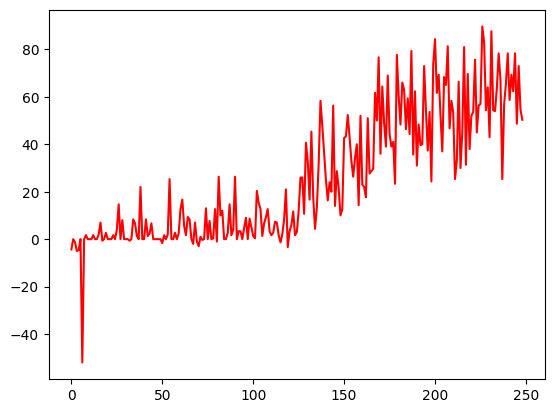

In [8]:
name = 'checkpoint'
plt.plot(Learner.rewards_eval,'r')
with open(name+'.pickle', 'wb') as f:
    pickle.dump(Learner.rewards_eval,f)
#plt.savefig('graphs_v3/'+name+'.png',dpi=300)
torch.save(Learner.model.state_dict(), name+'.pt')

# Clip a video

In [9]:
frames = Learner.clip(1000)
video = cv2.VideoWriter('video_episode.avi',cv2.VideoWriter_fourcc(*'XVID'),15, (128,128)) #path, encoding, frames per second, image size
for image in tqdm(frames):
    video.write(cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
video.release()

100%|████████████████████████████████████| 1000/1000 [00:00<00:00, 20313.47it/s]
